# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  


#### The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer. Now we change raw data to the useful format

In [1]:
%%capture
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install --upgrade delayed
!pip install -U sagemaker


In [3]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from collections import Counter
%matplotlib inline

# read in the json files
# portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
# profile = pd.read_json('data/profile.json', orient='records', lines=True)
# transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
# Preprocess portfolio data
DIR = 'data/'
portfolio = pd.read_json(DIR+'portfolio.json', orient='records', lines=True)
port_df = portfolio.copy()
# Chech duplicated data
print('Duplcated id: ',port_df['id'].duplicated().sum())
port_df.head()


Duplcated id:  0


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
def encode_df_col(df, col):
    '''
    df: DataFrame
    col: an encoded column of df
    '''
    sep_cols = pd.get_dummies(df[col].apply(pd.Series).stack()).groupby(level=0).sum()
    return pd.concat([df, sep_cols], axis=1)


In [6]:
# We encode offer_id into number data to see more clearly
offer_id_dict = {}
for k, id in enumerate(port_df['id']):
    offer_id_dict[id] = k
port_df['offer_id'] = port_df['id'].map(offer_id_dict)

# sep_channels = pd.get_dummies(port_df['channels'].apply(pd.Series).stack()).groupby(level=0).sum()
# port_df = pd.concat([port_df, sep_channels], axis = 1)

# rename port_df column to meaningful name
port_df = encode_df_col(port_df, 'channels')

port_df.rename(columns={"difficulty": "min_spend"}, inplace=True)

# Drop 2 renamed columns 
port_df.drop(columns=['channels', 'id'], axis=1, inplace=True)

# Encode the offer_type data
# sep_offer_types = pd.get_dummies(port_df['offer_type'])
# port_df = pd.concat([port_df, sep_offer_types], axis=1)
port_df = encode_df_col(port_df, 'offer_type')

port_df.drop(columns=['offer_type'], axis=1, inplace=True)

port_df.info()
print('\n', port_df)
port_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   reward         10 non-null     int64
 1   min_spend      10 non-null     int64
 2   duration       10 non-null     int64
 3   offer_id       10 non-null     int64
 4   email          10 non-null     uint8
 5   mobile         10 non-null     uint8
 6   social         10 non-null     uint8
 7   web            10 non-null     uint8
 8   bogo           10 non-null     uint8
 9   discount       10 non-null     uint8
 10  informational  10 non-null     uint8
dtypes: int64(4), uint8(7)
memory usage: 518.0 bytes

    reward  min_spend  duration  offer_id  email  mobile  social  web  bogo  \
0      10         10         7         0      1       1       1    0     1   
1      10         10         5         1      1       1       1    1     1   
2       0          0         4         2      1       1       0

,reward,min_spend,duration,offer_id,email,mobile,social,web,bogo,discount,informational
count,10.000000,10.000000,10.000000,10.00000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000,4.50000,1.0,0.900000,0.600000,0.800000,0.400000,0.400000,0.200000
std,3.583915,5.831905,2.321398,3.02765,0.0,0.316228,0.516398,0.421637,0.516398,0.516398,0.421637
min,0.000000,0.000000,3.000000,0.00000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,5.000000,2.25000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,4.000000,8.500000,7.000000,4.50000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,5.000000,10.000000,7.000000,6.75000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,10.000000,20.000000,10.000000,9.00000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# email = 1 for each row, its column is useless in our model. We delete column email
port_df.drop(columns = ['email'], axis=1, inplace=True)
# move offer_id column to the first.
def move_col_first(df, col_name):
    '''
    df: pandas DataFrame
    col_name: column is moved to the first column in df
    '''
    vals = df.pop(col_name)
    df.insert(0, col_name, vals)

move_col_first(port_df, 'offer_id')
port_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   offer_id       10 non-null     int64
 1   reward         10 non-null     int64
 2   min_spend      10 non-null     int64
 3   duration       10 non-null     int64
 4   mobile         10 non-null     uint8
 5   social         10 non-null     uint8
 6   web            10 non-null     uint8
 7   bogo           10 non-null     uint8
 8   discount       10 non-null     uint8
 9   informational  10 non-null     uint8
dtypes: int64(4), uint8(6)
memory usage: 508.0 bytes


In [8]:
# Check duplicated records and null values
print('Duplicated: ', port_df.duplicated().sum(), '\n---\nIsNull\n', port_df.isnull().sum())

Duplicated:  0 
---
IsNull
 offer_id         0
reward           0
min_spend        0
duration         0
mobile           0
social           0
web              0
bogo             0
discount         0
informational    0
dtype: int64


In [9]:
port_df

,offer_id,reward,min_spend,duration,mobile,social,web,bogo,discount,informational
0,0,10,10,7,1,1,0,1,0,0
1,1,10,10,5,1,1,1,1,0,0
2,2,0,0,4,1,0,1,0,0,1
3,3,5,5,7,1,0,1,1,0,0
4,4,5,20,10,0,0,1,0,1,0
5,5,3,7,7,1,1,1,0,1,0
6,6,2,10,10,1,1,1,0,1,0
7,7,0,0,3,1,1,0,0,0,1
8,8,5,5,5,1,1,1,1,0,0
9,9,2,10,7,1,0,1,0,1,0


### Profile data processing

In [10]:
# Preprocess profile data
profile = pd.read_json(DIR+'profile.json', orient='records', lines=True)
profile.info()
profile.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
prof_df = profile.copy()
# Examine null value in gender
print('Number of null value:',sum(prof_df['gender'].isna()))
prof_df['gender'].value_counts()

Number of null value: 2175


M    8484
F    6129
O     212
Name: gender, dtype: int64

In [12]:
# Number of null is large, we set null gender as gender 'D' - Different
prof_df['gender'].fillna('D', inplace=True)
# prof_df['gender'] = prof_df['gender'].astype('category')
prof_df['gender'].value_counts()

M    8484
F    6129
D    2175
O     212
Name: gender, dtype: int64

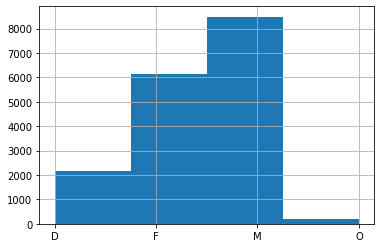

In [13]:
prof_df['gender'].hist(bins=4)

In [14]:
# Examine income data
print('Number of null income: ', prof_df['income'].isnull().sum())
prof_df['income'].describe()

Number of null income:  2175


count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

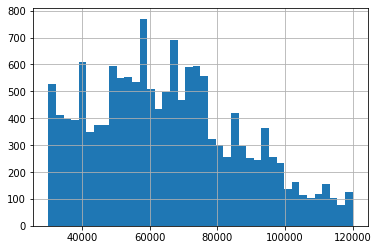

In [15]:
prof_df['income'].hist(bins=40)

Notice: Total number of gender D is equal to total number of unknown income data

120.0 30.0 2175


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2175


count     17000.000000
mean      66623.411765
std       22472.322961
min       30000.000000
25%       49000.000000
50%       65000.000000
75%       82000.000000
max      120000.000000
Name: income_rand, dtype: float64

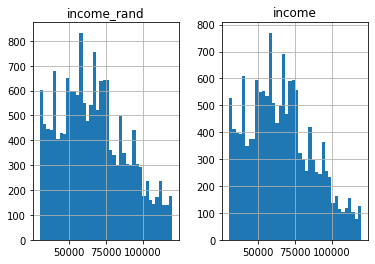

In [16]:
# Replace null value by a sequence of random dictribution data, saved in column 'income_rand'
import numpy.random as rd 
# mu, sigma = prof_df['income'].mean(), prof_df['income'].std()
max_inc = max(prof_df['income'].dropna())//1000
min_inc = min(prof_df['income'].dropna())//1000

null_income_indexs = prof_df['income'].isnull()
print(max_inc, min_inc, sum(null_income_indexs))
new_incomes = (np.random.randint(min_inc, max_inc, size=sum(null_income_indexs))*1000).tolist()
# new_incomes = (np.round(np.random.normal(mu, sigma, sum(null_income_indexs)), -3)).tolist()
prof_df['income_rand'] = prof_df['income'].copy()
indexs = []
i = 0
for k, val in enumerate(null_income_indexs):
    if val == True:
        indexs.append(k)
        prof_df['income_rand'][k] = new_incomes[i]
        i += 1
print(len(indexs))
new_incomes
# for k, val in enumerate
# prof_df['income_rand'].iloc[indexs] = new_incomes
prof_df[['income_rand', 'income']].hist(bins=40)
prof_df['income_rand'].describe()

##### Histogram doesn't change after modifying null value, and the mean value changes only a little.

In [17]:
# Try setting mean value for null income 
mean_inc = round(prof_df['income'].mean(), -3)
# max_inc = prof_df['income'].max()
prof_df['income_mean'] = prof_df['income'].fillna(mean_inc)

# prof_df['income'].describe()
# check null value prof_df
prof_df['income_mean'].isnull().sum()

0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f16c9b4dc50>,
      dtype=object)

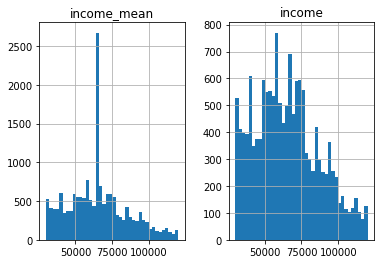

In [18]:
prof_df[['income_mean', 'income']].hist(bins=40)

##### Histogram are much different. We choose 'income_rand' to use later 

In [19]:
prof_df.drop(['income_mean', 'income'], axis=1, inplace=True)

In [20]:
# Change column name for knowing easily what ther are.
prof_df_cols_change = {'became_member_on': 'time_on', 'id': 'customer_id'}
prof_df.rename(prof_df_cols_change, axis=1, inplace=True)
prof_df.info()
prof_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       17000 non-null  object 
 1   age          17000 non-null  int64  
 2   customer_id  17000 non-null  object 
 3   time_on      17000 non-null  int64  
 4   income_rand  17000 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


,gender,age,customer_id,time_on,income_rand
0,D,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,31000.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,D,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,94000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,D,118,a03223e636434f42ac4c3df47e8bac43,20170804,117000.0


In [21]:
# Check size
prof_df.shape

(17000, 5)

In [22]:
# Set datetime type for 'time_on' value.
prof_df['time_on'] = pd.to_datetime(prof_df['time_on'],format='%Y%m%d')
prof_df.info()
prof_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   gender       17000 non-null  object        
 1   age          17000 non-null  int64         
 2   customer_id  17000 non-null  object        
 3   time_on      17000 non-null  datetime64[ns]
 4   income_rand  17000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


,gender,age,customer_id,time_on,income_rand
0,D,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,31000.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,D,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,94000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,D,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,117000.0


In [23]:
# check the unique customer_ids 
prof_df['customer_id'].duplicated().sum()

0

In [24]:
# Change the customer_id to number for easy view.
customer_dict = {}
for k, id in enumerate(prof_df['customer_id']):
    customer_dict[id] = k

prof_df['customer_id'] = prof_df['customer_id'].map(customer_dict)
prof_df.info()
prof_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   gender       17000 non-null  object        
 1   age          17000 non-null  int64         
 2   customer_id  17000 non-null  int64         
 3   time_on      17000 non-null  datetime64[ns]
 4   income_rand  17000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 664.2+ KB


,gender,age,customer_id,time_on,income_rand
0,D,118,0,2017-02-12,31000.0
1,F,55,1,2017-07-15,112000.0
2,D,118,2,2018-07-12,94000.0
3,F,75,3,2017-05-09,100000.0
4,D,118,4,2017-08-04,117000.0


In [25]:
prof_df['gender'][prof_df['age'] == 118].unique()
# array(['D'], dtype=object)

array(['D'], dtype=object)

##### People that don't set gender (D) is set age 118

In [26]:
# Encode the gender value
prof_df['gender'] = prof_df['gender'].astype('object')
prof_df = encode_df_col(prof_df, 'gender')

prof_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   gender       17000 non-null  object        
 1   age          17000 non-null  int64         
 2   customer_id  17000 non-null  int64         
 3   time_on      17000 non-null  datetime64[ns]
 4   income_rand  17000 non-null  float64       
 5   D            17000 non-null  uint8         
 6   F            17000 non-null  uint8         
 7   M            17000 non-null  uint8         
 8   O            17000 non-null  uint8         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1), uint8(4)
memory usage: 730.6+ KB


In [27]:
# Change the 1st column
move_col_first(prof_df, 'customer_id')
prof_df.info()
prof_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  17000 non-null  int64         
 1   gender       17000 non-null  object        
 2   age          17000 non-null  int64         
 3   time_on      17000 non-null  datetime64[ns]
 4   income_rand  17000 non-null  float64       
 5   D            17000 non-null  uint8         
 6   F            17000 non-null  uint8         
 7   M            17000 non-null  uint8         
 8   O            17000 non-null  uint8         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1), uint8(4)
memory usage: 730.6+ KB


customer_id    0
gender         0
age            0
time_on        0
income_rand    0
D              0
F              0
M              0
O              0
dtype: int64

### Transcript data


In [28]:
# Examine transcript data
transcript = pd.read_json(DIR+'transcript.json', orient='records', lines=True)
tran_df = transcript.copy()
tran_df.info()
# tran_df.describe()
tran_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [29]:
# Transform person value into customer_id
tran_df['customer_id']  = tran_df['person'].map(customer_dict)
# tran_df['customer_id'].isnull().sum()
tran_df.drop(columns=['person'], axis=1, inplace=True)
tran_df.head()

,event,value,time,customer_id
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,3
1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,4
2,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,5
3,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,6
4,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,7


In [30]:
# Check if the total number of  customer_id is correct.
len(tran_df['customer_id'].unique())

17000

In [31]:
# Examine the event data
tran_df['event'].unique() 

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [32]:
# Encode the event data into 4 columns
tran_df['event'] = tran_df['event'].str.replace(' ','_')
tran_df = encode_df_col(tran_df, 'event')
# sep_offers = pd.get_dummies(tran_df['event'].str.replace(' ','_'))
# tran_df = pd.concat([tran_df, sep_offers], axis=1)
tran_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event            306534 non-null  object
 1   value            306534 non-null  object
 2   time             306534 non-null  int64 
 3   customer_id      306534 non-null  int64 
 4   offer_completed  306534 non-null  uint8 
 5   offer_received   306534 non-null  uint8 
 6   offer_viewed     306534 non-null  uint8 
 7   transaction      306534 non-null  uint8 
dtypes: int64(2), object(2), uint8(4)
memory usage: 10.5+ MB


In [33]:
# Examine tran_df 'value' data
print(tran_df['value'].head(10),'\n---\n',tran_df['value'].tail(10))

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6    {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7    {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
Name: value, dtype: object 
---
 306524                                    {'amount': 25.14}
306525                                    {'amount': 43.58}
306526                                    {'amount': 22.64}
306527    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306528                                      {'amount': 2.2}
306529                       {'amount': 1.5899999999999999}
306530                                     {'amount': 9.53}
306531 

In [34]:
# Examine the tran_df['value'] data. We use set data type to get all the distinct key values  
myset = set()
for dict in tran_df['value']:
    for key in dict.keys():
        myset.add(key)
print(myset)

{'offer_id', 'reward', 'offer id', 'amount'}


#### There are 3 types of data in 'value'; 'offer id' and 'offer_id' have the same meaning. 

In [35]:
# Write 3 functions to encode the value column into 3 other columns offer_id, reward, and amount
def get_offer_id(dict):
    for key in dict.keys():
        if 'offer' in key:
            return dict[key]
    # We use 10 for the other offer_id (different to original {0, 1, ...,9} in portfolio data).
    return 10
        
def get_reward(dict):
    for key in dict.keys():
        if 'reward' in key:
            return dict[key]
    # If no reward we set 0
    return 0
        
def get_amount(dict):
    for key in dict.keys():
        if 'amount' in key:
            return dict[key]
    # If no amount we set 0
    return 0
    

In [36]:
# Create 3 columns to encode the column 'value'
tran_df['offer_id'] = tran_df['value'].apply(get_offer_id)
tran_df['reward'] = tran_df['value'].apply(get_reward)
tran_df['amount'] = tran_df['value'].apply(get_amount)
tran_df.tail(20)

,event,value,time,customer_id,offer_completed,offer_received,offer_viewed,transaction,offer_id,reward,amount
306514,transaction,{'amount': 8.2},714,16836,0,0,0,1,10,0,8.20
306515,transaction,{'amount': 2.6},714,16847,0,0,0,1,10,0,2.60
306516,transaction,{'amount': 9.2},714,16848,0,0,0,1,10,0,9.20
306517,transaction,{'amount': 11.7},714,16849,0,0,0,1,10,0,11.70
306518,transaction,{'amount': 40.67},714,16864,0,0,0,1,10,0,40.67
306519,transaction,{'amount': 31.13},714,16865,0,0,0,1,10,0,31.13
306520,transaction,{'amount': 1.6400000000000001},714,16900,0,0,0,1,10,0,1.64
306521,transaction,{'amount': 17.35},714,16912,0,0,0,1,10,0,17.35
306522,transaction,{'amount': 4.42},714,16914,0,0,0,1,10,0,4.42
306523,transaction,{'amount': 18.35},714,16918,0,0,0,1,10,0,18.35


In [37]:
tran_df.info()
tran_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   event            306534 non-null  object 
 1   value            306534 non-null  object 
 2   time             306534 non-null  int64  
 3   customer_id      306534 non-null  int64  
 4   offer_completed  306534 non-null  uint8  
 5   offer_received   306534 non-null  uint8  
 6   offer_viewed     306534 non-null  uint8  
 7   transaction      306534 non-null  uint8  
 8   offer_id         306534 non-null  object 
 9   reward           306534 non-null  int64  
 10  amount           306534 non-null  float64
dtypes: float64(1), int64(3), object(3), uint8(4)
memory usage: 17.5+ MB


,time,customer_id,offer_completed,offer_received,offer_viewed,transaction,reward,amount
count,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000
mean,366.382940,8500.102374,0.109544,0.248837,0.188315,0.453304,0.537219,5.792023
std,200.326314,4901.913992,0.312321,0.432340,0.390964,0.497815,1.805208,21.337137
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,186.000000,4264.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,408.000000,8498.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,528.000000,12730.000000,0.000000,0.000000,0.000000,1.000000,0.000000,7.100000
max,714.000000,16999.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1062.280000


In [38]:
# Remove 2 columns 'event, 'value after encoding
tran_df_cols_drop =['event', 'value']
# tran_df_cols_drop =['value']
tran_df.drop(columns=tran_df_cols_drop, axis=1, inplace=True)


In [39]:
# Examine tran_df['offer_id'] 
tran_df['offer_id'].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837', 10], dtype=object)

In [40]:
# 10 is the unreal offer_id, we modify offer_id_dict for mapping
if 10 not in offer_id_dict.keys():
    offer_id_dict[10] = 10
tran_df['offer_id'] = tran_df['offer_id'].map(offer_id_dict)
tran_df['offer_id'].unique()

array([ 3,  4,  9,  6,  1,  8,  5,  2,  0,  7, 10])

In [41]:
tran_df['offer_id'].isnull().sum()

0

In [42]:
# Hide offer_id 10 to check reward data in trans
tmp_trans = tran_df[['offer_id', 'reward']][tran_df['offer_id'] != 10]
tmp_trans.info()
tmp_trans.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   offer_id  167581 non-null  int64
 1   reward    167581 non-null  int64
dtypes: int64(2)
memory usage: 3.8 MB


,offer_id,reward
0,3,0
1,4,0
2,9,0
3,6,0
4,1,0


In [43]:
# check the reward values in transaction and compare to the reward value in portfolio
check_id = tmp_trans['offer_id'].unique()
dict = {}
for id in check_id:
    dict[id] = list(tmp_trans['reward'][tmp_trans['offer_id'] == id].unique())
print(dict, '\n___\n', port_df[['offer_id', 'reward']])

{3: [0, 5], 4: [0, 5], 9: [0, 2], 6: [0, 2], 1: [0, 10], 8: [0, 5], 5: [0, 3], 2: [0], 0: [0, 10], 7: [0]} 
___
    offer_id  reward
0         0      10
1         1      10
2         2       0
3         3       5
4         4       5
5         5       3
6         6       2
7         7       0
8         8       5
9         9       2


##### We remove column tran_df['reward'], its values 0 are not compatible with portfolio reward value, maybe the data recorder thinks the reward value can be got from offer_id. We will use value reward from port_df for consistancy.

In [44]:
tran_df.drop(columns=['reward'], axis=1, inplace=True)
move_col_first(tran_df, 'customer_id')
# check the columns name of tran_df and prof_df before merging
print(tran_df.columns, '\n---\n', prof_df.columns)
tran_df.info()

Index(['customer_id', 'time', 'offer_completed', 'offer_received',
       'offer_viewed', 'transaction', 'offer_id', 'amount'],
      dtype='object') 
---
 Index(['customer_id', 'gender', 'age', 'time_on', 'income_rand', 'D', 'F', 'M',
       'O'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      306534 non-null  int64  
 1   time             306534 non-null  int64  
 2   offer_completed  306534 non-null  uint8  
 3   offer_received   306534 non-null  uint8  
 4   offer_viewed     306534 non-null  uint8  
 5   transaction      306534 non-null  uint8  
 6   offer_id         306534 non-null  int64  
 7   amount           306534 non-null  float64
dtypes: float64(1), int64(3), uint8(4)
memory usage: 10.5 MB


### Combine 3 dataframes to have a full usefull related data. 

In [45]:
# Merge tran_df and prof_df
data = pd.merge(tran_df, prof_df, on='customer_id')

In [46]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   customer_id      306534 non-null  int64         
 1   time             306534 non-null  int64         
 2   offer_completed  306534 non-null  uint8         
 3   offer_received   306534 non-null  uint8         
 4   offer_viewed     306534 non-null  uint8         
 5   transaction      306534 non-null  uint8         
 6   offer_id         306534 non-null  int64         
 7   amount           306534 non-null  float64       
 8   gender           306534 non-null  object        
 9   age              306534 non-null  int64         
 10  time_on          306534 non-null  datetime64[ns]
 11  income_rand      306534 non-null  float64       
 12  D                306534 non-null  uint8         
 13  F                306534 non-null  uint8         
 14  M                306

customer_id        0
time               0
offer_completed    0
offer_received     0
offer_viewed       0
transaction        0
offer_id           0
amount             0
gender             0
age                0
time_on            0
income_rand        0
D                  0
F                  0
M                  0
O                  0
dtype: int64

In [47]:
# Check the columns name before merging
print(data.columns,'\n---\n', port_df.columns)

Index(['customer_id', 'time', 'offer_completed', 'offer_received',
       'offer_viewed', 'transaction', 'offer_id', 'amount', 'gender', 'age',
       'time_on', 'income_rand', 'D', 'F', 'M', 'O'],
      dtype='object') 
---
 Index(['offer_id', 'reward', 'min_spend', 'duration', 'mobile', 'social',
       'web', 'bogo', 'discount', 'informational'],
      dtype='object')


In [48]:
# Merging on 'offer_id'
data = pd.merge(data, port_df, on='offer_id', how='left')
data.info()
# data.head()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   customer_id      306534 non-null  int64         
 1   time             306534 non-null  int64         
 2   offer_completed  306534 non-null  uint8         
 3   offer_received   306534 non-null  uint8         
 4   offer_viewed     306534 non-null  uint8         
 5   transaction      306534 non-null  uint8         
 6   offer_id         306534 non-null  int64         
 7   amount           306534 non-null  float64       
 8   gender           306534 non-null  object        
 9   age              306534 non-null  int64         
 10  time_on          306534 non-null  datetime64[ns]
 11  income_rand      306534 non-null  float64       
 12  D                306534 non-null  uint8         
 13  F                306534 non-null  uint8         
 14  M                306

customer_id             0
time                    0
offer_completed         0
offer_received          0
offer_viewed            0
transaction             0
offer_id                0
amount                  0
gender                  0
age                     0
time_on                 0
income_rand             0
D                       0
F                       0
M                       0
O                       0
reward             138953
min_spend          138953
duration           138953
mobile             138953
social             138953
web                138953
bogo               138953
discount           138953
informational      138953
dtype: int64

In [49]:
# Find sample null value
data['offer_id'][data['bogo'].isnull()].value_counts()

10    138953
Name: offer_id, dtype: int64

In [50]:
# # 138953 rows of null value. We check the oofer_id 10 - informational
sum(data['offer_id'] == 10)

138953

In [51]:
# Drop NA value, their values are only informational. No effect to our prediction 
# data.dropna(inplace=True)
data = data[data['offer_id'] != 10]
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306532
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   customer_id      167581 non-null  int64         
 1   time             167581 non-null  int64         
 2   offer_completed  167581 non-null  uint8         
 3   offer_received   167581 non-null  uint8         
 4   offer_viewed     167581 non-null  uint8         
 5   transaction      167581 non-null  uint8         
 6   offer_id         167581 non-null  int64         
 7   amount           167581 non-null  float64       
 8   gender           167581 non-null  object        
 9   age              167581 non-null  int64         
 10  time_on          167581 non-null  datetime64[ns]
 11  income_rand      167581 non-null  float64       
 12  D                167581 non-null  uint8         
 13  F                167581 non-null  uint8         
 14  M                167

customer_id        0
time               0
offer_completed    0
offer_received     0
offer_viewed       0
transaction        0
offer_id           0
amount             0
gender             0
age                0
time_on            0
income_rand        0
D                  0
F                  0
M                  0
O                  0
reward             0
min_spend          0
duration           0
mobile             0
social             0
web                0
bogo               0
discount           0
informational      0
dtype: int64

In [52]:
# Rename 'offer_completed' into "success" to get meaningful column
data.rename(columns={'offer_completed': "success"}, inplace=True)
move_col_first(data, 'success')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306532
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   success         167581 non-null  uint8         
 1   customer_id     167581 non-null  int64         
 2   time            167581 non-null  int64         
 3   offer_received  167581 non-null  uint8         
 4   offer_viewed    167581 non-null  uint8         
 5   transaction     167581 non-null  uint8         
 6   offer_id        167581 non-null  int64         
 7   amount          167581 non-null  float64       
 8   gender          167581 non-null  object        
 9   age             167581 non-null  int64         
 10  time_on         167581 non-null  datetime64[ns]
 11  income_rand     167581 non-null  float64       
 12  D               167581 non-null  uint8         
 13  F               167581 non-null  uint8         
 14  M               167581 non-null  uin

In [53]:
change_type_cols = ['reward', 'min_spend', 'duration', 'mobile', 'social', 'web',
       'bogo', 'discount', 'informational', 'offer_id', 'age']
for col in change_type_cols:
    data[col] = data[col].astype('uint8')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306532
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   success         167581 non-null  uint8         
 1   customer_id     167581 non-null  int64         
 2   time            167581 non-null  int64         
 3   offer_received  167581 non-null  uint8         
 4   offer_viewed    167581 non-null  uint8         
 5   transaction     167581 non-null  uint8         
 6   offer_id        167581 non-null  uint8         
 7   amount          167581 non-null  float64       
 8   gender          167581 non-null  object        
 9   age             167581 non-null  uint8         
 10  time_on         167581 non-null  datetime64[ns]
 11  income_rand     167581 non-null  float64       
 12  D               167581 non-null  uint8         
 13  F               167581 non-null  uint8         
 14  M               167581 non-null  uin

In [54]:
data.to_csv(DIR+'raw_data.csv', index=False)

In [55]:
data.describe()

,success,customer_id,time,offer_received,offer_viewed,transaction,offer_id,amount,age,income_rand,...,O,reward,min_spend,duration,mobile,social,web,bogo,discount,informational
count,167581.000000,167581.00000,167581.000000,167581.000000,167581.000000,167581.0,167581.000000,167581.0,167581.000000,167581.000000,...,167581.000000,167581.00000,167581.000000,167581.000000,167581.000000,167581.000000,167581.000000,167581.000000,167581.000000,167581.000000
mean,0.200375,8495.77988,353.778412,0.455165,0.344460,0.0,4.550522,0.0,61.862616,67367.219434,...,0.013068,4.41991,7.850401,6.610737,0.917944,0.656996,0.806858,0.427358,0.417100,0.155543
std,0.400282,4902.64644,198.301287,0.497987,0.475193,0.0,2.885785,0.0,25.693155,22251.875521,...,0.113568,3.37336,5.048944,2.136130,0.274451,0.474714,0.394765,0.494696,0.493081,0.362422
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,18.000000,30000.000000,...,0.000000,0.00000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4253.00000,168.000000,0.000000,0.000000,0.0,2.000000,0.0,45.000000,51000.000000,...,0.000000,2.00000,5.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,8487.00000,408.000000,0.000000,0.000000,0.0,5.000000,0.0,58.000000,66000.000000,...,0.000000,5.00000,10.000000,7.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,12735.00000,510.000000,1.000000,1.000000,0.0,7.000000,0.0,72.000000,83000.000000,...,0.000000,5.00000,10.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,16999.00000,714.000000,1.000000,1.000000,0.0,9.000000,0.0,118.000000,120000.000000,...,1.000000,10.00000,20.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Examine and process data related to success

In [56]:
data[['offer_viewed', 'bogo']].groupby(
    ['bogo'], as_index=False).mean().sort_values(
    by='bogo', ascending=False)

,bogo,offer_viewed
1,1,0.355349
0,0,0.336334


In [57]:
data[['offer_viewed', 'discount']].groupby(
    ['discount'], as_index=False).mean().sort_values(
    by='discount', ascending=False)

,discount,offer_viewed
1,1,0.306804
0,0,0.371405


In [58]:
print('data shape', data.shape)
data['success'].value_counts()

data shape (167581, 25)


0    134002
1     33579
Name: success, dtype: int64

In [59]:
# set inds is the indexs of rows with success = 1 
inds = data['success'] == 1
num_success = sum(inds)
num_success

33579

In [60]:
data['informational'][inds].value_counts()

0    33579
Name: informational, dtype: int64

In [61]:
data['transaction'].value_counts()

0    167581
Name: transaction, dtype: int64

In [62]:
# Column informational is not necessary for examining success data
data.drop(columns=['informational'], axis=1, inplace=True)

In [63]:
data['offer_id'][inds].value_counts()
# offer_id 2, 7 & 10 don't affect the success data - informational offers.
#  We can remove them

6    5317
5    5156
3    4354
8    4296
9    4017
0    3688
4    3420
1    3331
Name: offer_id, dtype: int64

In [64]:
# offer_id 2, 7 & 10 don't affect the success data - informational offers.
#  We can remove them
data = data[data['offer_id'] != 2]
data = data[data['offer_id'] != 7]
data = data[data['offer_id'] != 10]

data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141515 entries, 0 to 306532
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   success         141515 non-null  uint8         
 1   customer_id     141515 non-null  int64         
 2   time            141515 non-null  int64         
 3   offer_received  141515 non-null  uint8         
 4   offer_viewed    141515 non-null  uint8         
 5   transaction     141515 non-null  uint8         
 6   offer_id        141515 non-null  uint8         
 7   amount          141515 non-null  float64       
 8   gender          141515 non-null  object        
 9   age             141515 non-null  uint8         
 10  time_on         141515 non-null  datetime64[ns]
 11  income_rand     141515 non-null  float64       
 12  D               141515 non-null  uint8         
 13  F               141515 non-null  uint8         
 14  M               141515 non-null  uin

(141515, 24)

In [65]:
data['amount'].value_counts()

0.0    141515
Name: amount, dtype: int64

In [66]:
# Remove data['amount'], it's useless for our prediction
data.drop(columns=['amount'], axis=1, inplace=True)

In [67]:
# Success ratio on the success data
gender_success = {}
# success = sum(data['success'] == 1)
for col in ['F', 'M', 'O', 'D']:
#     gender_success[col] = data[col][data['success'] == 1].value_counts()
    gender_success[col] = sum(data[col][data['success'] == 1] == 1) / num_success
    print(f'Success ratio {col}: {gender_success[col]: .04f}')

print(gender_success)
# print('Number success: ',success)


Success ratio F:  0.4609
Success ratio M:  0.4904
Success ratio O:  0.0149
Success ratio D:  0.0338
{'F': 0.46091307066916826, 'M': 0.4903660025611245, 'O': 0.014920039310283214, 'D': 0.03380088745942404}


In [68]:
# Success ratio on the whole data
data[["gender", "success"]].groupby(
    ['gender'], as_index=False).mean().sort_values(
    by='success', ascending=False)

,gender,success
1,F,0.285180
3,O,0.273173
2,M,0.235094
0,D,0.073845


In [69]:
# Success ratio on the whole data
data[["gender", "bogo"]].groupby(
    ['gender'], as_index=False).mean().sort_values(
    by='bogo', ascending=False)

,gender,bogo
1,F,0.508909
0,D,0.506376
2,M,0.504012
3,O,0.498364


In [70]:
# Success ratio on the whole data
data[["gender", "discount"]].groupby(
    ['gender'], as_index=False).mean().sort_values(
    by='discount', ascending=False)

,gender,discount
3,O,0.501636
2,M,0.495988
0,D,0.493624
1,F,0.491091


In [71]:
offer_type_success = {}
for col in ['bogo', 'discount']:
    offer_type_success[col] = sum(data[col][inds])

print('The total number of offer_type_success: ', offer_type_success)

The total number of offer_type_success:  {'bogo': 15669, 'discount': 17910}


In [72]:
print(f'Number of bogo offer: {sum(data["bogo"] == 1)}', 
      f'\nNumber of discount offer: {sum(data["discount"] == 1)}')

Number of bogo offer: 71617 
Number of discount offer: 69898


In [73]:
# Save data file 'dat.csv'
data.to_csv(DIR+'data.csv', index=False)

In [74]:
data[["gender","bogo", "success"]].groupby(
    ["gender",'bogo'], as_index=False).mean().sort_values(
    by='success', ascending=False)

,gender,bogo,success
2,F,0,0.299265
6,O,0,0.278261
3,F,1,0.271588
7,O,1,0.268053
4,M,0,0.257751
5,M,1,0.212799
0,D,0,0.095426
1,D,1,0.052807


In [75]:
data[["gender", "discount", "success"]].groupby(
    ["gender",'discount'], as_index=False).mean().sort_values(
    by='success', ascending=False)

,gender,discount,success
3,F,1,0.299265
7,O,1,0.278261
2,F,0,0.271588
6,O,0,0.268053
5,M,1,0.257751
4,M,0,0.212799
1,D,1,0.095426
0,D,0,0.052807


#### The success ratio of Female is highest, next is the success ratio of Male 

In [76]:
cust_ages = data['age'][inds].value_counts()
cust_ages

118    1135
58      977
53      896
57      864
59      850
       ... 
96       27
97       27
99       18
101      12
98        6
Name: age, Length: 85, dtype: int64

In [77]:
dt_age = data[['age']][inds]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f16a03dd050>]],
      dtype=object)

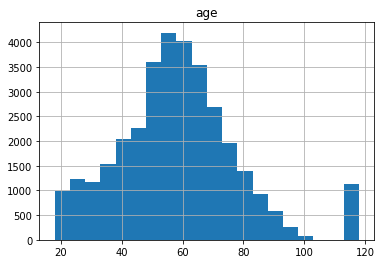

In [78]:
dt_age.hist(bins=20)

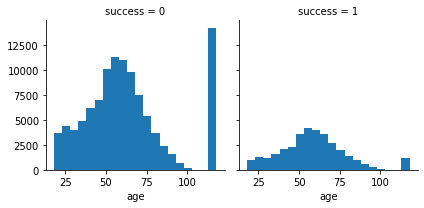

In [79]:
g = sns.FacetGrid(data, col='success')
g.map(plt.hist, 'age', bins=20)

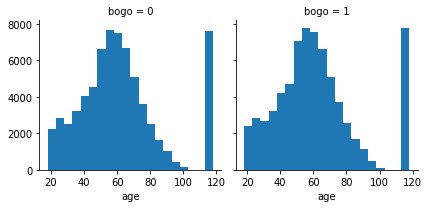

In [80]:
g_bogo = sns.FacetGrid(data, col='bogo')
g_bogo.map(plt.hist, 'age', bins=20)

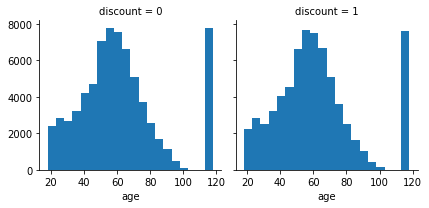

In [81]:
g_disc = sns.FacetGrid(data, col='discount')
g_disc.map(plt.hist, 'age', bins=20)

In [82]:
# According to the above plots, we can group by 5 range
# age1 < 30, age2 < 50, age3 < 75, age4 < 90, age5 rest 
def age_class_create(age):
    if age < 30:
        return 1
    elif age < 50:
        return 2
    elif age < 75:
        return 3
    elif age < 85:
        return 4
    return 5
data['age_class'] = data['age'].apply(age_class_create)
data['age_class'][inds].value_counts()

3    17623
2     7868
4     2876
1     2706
5     2506
Name: age_class, dtype: int64

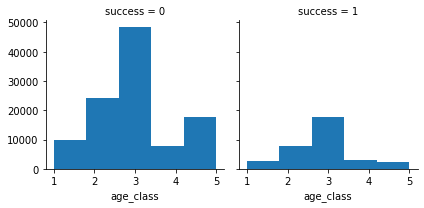

In [83]:
g_ageclass = sns.FacetGrid(data, col='success')
g_ageclass.map(plt.hist, 'age_class', bins=5)

##### The highest success ratio in age_class from 30-75

In [84]:
dt_income = data['income_rand'][inds]

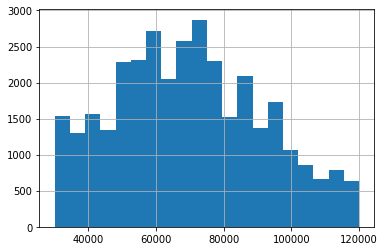

In [85]:
dt_income.hist(bins=20)

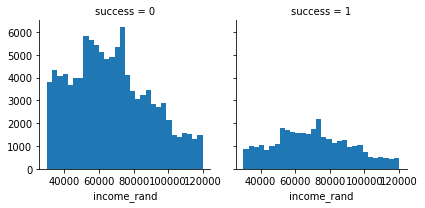

In [86]:
h = sns.FacetGrid(data, col='success')
h.map(plt.hist, 'income_rand', bins=30)

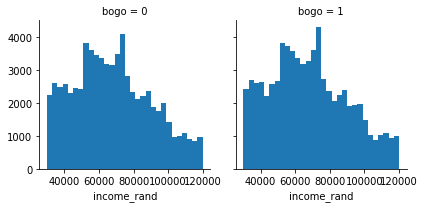

In [87]:
h_bogo = sns.FacetGrid(data, col='bogo')
h_bogo.map(plt.hist, 'income_rand', bins=30)

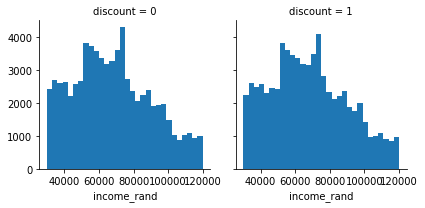

In [88]:
h_disc = sns.FacetGrid(data, col='discount')
h_disc.map(plt.hist, 'income_rand', bins=30)

In [89]:
# From the above plots, we can group income into 4 classes
# inc1 < 50k, inc2 < 80k, inc3 < 100k , inc4 rest 
def income_class_create(income):
    if income < 50000:
        return 1
    elif income < 80000:
        return 2
    elif income < 100000:
        return 3
    return 4

data['income_class'] = data['income_rand'].apply(income_class_create)
data['income_class'][inds].value_counts()

2    16507
3     7403
1     6340
4     3329
Name: income_class, dtype: int64

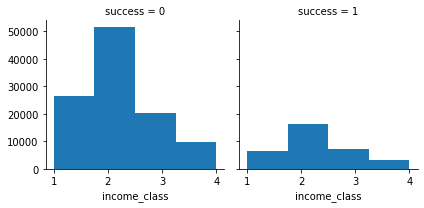

In [90]:
h_inclass = sns.FacetGrid(data, col='success')
h_inclass.map(plt.hist, 'income_class', bins=4)

##### The highest success ratio is income_class 2 and 3 - (50.000 - 80.000 -100.000)

In [91]:
for col in ['age_class', 'income_class']:
    data[col] = data[col].astype('uint8')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141515 entries, 0 to 306532
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   success         141515 non-null  uint8         
 1   customer_id     141515 non-null  int64         
 2   time            141515 non-null  int64         
 3   offer_received  141515 non-null  uint8         
 4   offer_viewed    141515 non-null  uint8         
 5   transaction     141515 non-null  uint8         
 6   offer_id        141515 non-null  uint8         
 7   gender          141515 non-null  object        
 8   age             141515 non-null  uint8         
 9   time_on         141515 non-null  datetime64[ns]
 10  income_rand     141515 non-null  float64       
 11  D               141515 non-null  uint8         
 12  F               141515 non-null  uint8         
 13  M               141515 non-null  uint8         
 14  O               141515 non-null  uin

In [92]:
data['year'] = data['time_on'].dt.year
data['year'][inds].value_counts()

2017    12595
2016     9298
2018     5295
2015     4489
2014     1334
2013      568
Name: year, dtype: int64

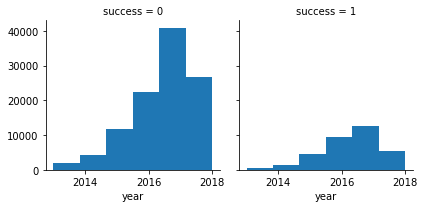

In [93]:
year_bins = len(data['year'].unique())
g_year = sns.FacetGrid(data, col='success')
g_year.map(plt.hist, 'year', bins=year_bins)

In [94]:
data = encode_df_col(data,'year')
# data.drop(columns=['time_on', 'year'], axis=1, inplace=True)
# data.drop(columns=['year'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141515 entries, 0 to 306532
Data columns (total 32 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   success         141515 non-null  uint8         
 1   customer_id     141515 non-null  int64         
 2   time            141515 non-null  int64         
 3   offer_received  141515 non-null  uint8         
 4   offer_viewed    141515 non-null  uint8         
 5   transaction     141515 non-null  uint8         
 6   offer_id        141515 non-null  uint8         
 7   gender          141515 non-null  object        
 8   age             141515 non-null  uint8         
 9   time_on         141515 non-null  datetime64[ns]
 10  income_rand     141515 non-null  float64       
 11  D               141515 non-null  uint8         
 12  F               141515 non-null  uint8         
 13  M               141515 non-null  uint8         
 14  O               141515 non-null  uin

In [95]:
data['offer_received'][inds].value_counts()


0    33579
Name: offer_received, dtype: int64

In [96]:
# Remove unnecessary columns
# Remove data['offer_received'] 
data.drop(columns=['offer_received', 'income_rand', 'gender', 
                   'year', 'transaction', 'age'], 
          axis=1, inplace=True)
# data.drop(columns=['offer_received'], axis=1, inplace=True)


In [97]:
# data.drop(columns=['transaction', 'gender', 'age', 'income_rand'], axis=1, inplace=True)
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141515 entries, 0 to 306532
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   success       141515 non-null  uint8         
 1   customer_id   141515 non-null  int64         
 2   time          141515 non-null  int64         
 3   offer_viewed  141515 non-null  uint8         
 4   offer_id      141515 non-null  uint8         
 5   time_on       141515 non-null  datetime64[ns]
 6   D             141515 non-null  uint8         
 7   F             141515 non-null  uint8         
 8   M             141515 non-null  uint8         
 9   O             141515 non-null  uint8         
 10  reward        141515 non-null  uint8         
 11  min_spend     141515 non-null  uint8         
 12  duration      141515 non-null  uint8         
 13  mobile        141515 non-null  uint8         
 14  social        141515 non-null  uint8         
 15  web           141

,success,customer_id,time,offer_viewed,offer_id,D,F,M,O,reward,...,bogo,discount,age_class,income_class,2013,2014,2015,2016,2017,2018
count,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.00000,141515.000000,141515.000000,141515.000000,...,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000
mean,0.237282,8488.114256,355.953927,0.331371,4.514885,0.108610,0.38350,0.494930,0.012960,5.234025,...,0.506074,0.493926,2.958831,2.151249,0.016846,0.040399,0.113825,0.223637,0.378356,0.226937
std,0.425418,4904.150966,198.172446,0.470708,2.951825,0.311151,0.48624,0.499976,0.113101,3.035536,...,0.499965,0.499965,1.108320,0.881357,0.128696,0.196893,0.317600,0.416683,0.484979,0.418853
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4232.500000,174.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.000000,...,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,8475.000000,408.000000,0.000000,5.000000,0.000000,0.00000,0.000000,0.000000,5.000000,...,1.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,12733.000000,510.000000,1.000000,6.000000,0.000000,1.00000,1.000000,0.000000,10.000000,...,1.000000,1.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,16999.000000,714.000000,1.000000,9.000000,1.000000,1.00000,1.000000,1.000000,10.000000,...,1.000000,1.000000,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
data.to_csv(DIR+'pdata.csv', index=False)

In [99]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141515 entries, 0 to 306532
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   success       141515 non-null  uint8         
 1   customer_id   141515 non-null  int64         
 2   time          141515 non-null  int64         
 3   offer_viewed  141515 non-null  uint8         
 4   offer_id      141515 non-null  uint8         
 5   time_on       141515 non-null  datetime64[ns]
 6   D             141515 non-null  uint8         
 7   F             141515 non-null  uint8         
 8   M             141515 non-null  uint8         
 9   O             141515 non-null  uint8         
 10  reward        141515 non-null  uint8         
 11  min_spend     141515 non-null  uint8         
 12  duration      141515 non-null  uint8         
 13  mobile        141515 non-null  uint8         
 14  social        141515 non-null  uint8         
 15  web           141

,success,customer_id,time,offer_viewed,offer_id,D,F,M,O,reward,...,bogo,discount,age_class,income_class,2013,2014,2015,2016,2017,2018
count,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.00000,141515.000000,141515.000000,141515.000000,...,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000
mean,0.237282,8488.114256,355.953927,0.331371,4.514885,0.108610,0.38350,0.494930,0.012960,5.234025,...,0.506074,0.493926,2.958831,2.151249,0.016846,0.040399,0.113825,0.223637,0.378356,0.226937
std,0.425418,4904.150966,198.172446,0.470708,2.951825,0.311151,0.48624,0.499976,0.113101,3.035536,...,0.499965,0.499965,1.108320,0.881357,0.128696,0.196893,0.317600,0.416683,0.484979,0.418853
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4232.500000,174.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.000000,...,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,8475.000000,408.000000,0.000000,5.000000,0.000000,0.00000,0.000000,0.000000,5.000000,...,1.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,12733.000000,510.000000,1.000000,6.000000,0.000000,1.00000,1.000000,0.000000,10.000000,...,1.000000,1.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,16999.000000,714.000000,1.000000,9.000000,1.000000,1.00000,1.000000,1.000000,10.000000,...,1.000000,1.000000,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.

In [100]:
# data has 141.515 rows and 26 columns
inds=data['success'] == 1
print('Number of success: ',sum(inds))
print('---\n',data['offer_id'][inds].value_counts() )


Number of success:  33579
---
 6    5317
5    5156
3    4354
8    4296
9    4017
0    3688
4    3420
1    3331
Name: offer_id, dtype: int64


In [101]:
# Process data time_on
data['time_on'] = pd.to_datetime(data['time_on'],format='%Y-%m-%d')
data['time_on'] = data['time_on'].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141515 entries, 0 to 306532
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   success       141515 non-null  uint8
 1   customer_id   141515 non-null  int64
 2   time          141515 non-null  int64
 3   offer_viewed  141515 non-null  uint8
 4   offer_id      141515 non-null  uint8
 5   time_on       141515 non-null  int64
 6   D             141515 non-null  uint8
 7   F             141515 non-null  uint8
 8   M             141515 non-null  uint8
 9   O             141515 non-null  uint8
 10  reward        141515 non-null  uint8
 11  min_spend     141515 non-null  uint8
 12  duration      141515 non-null  uint8
 13  mobile        141515 non-null  uint8
 14  social        141515 non-null  uint8
 15  web           141515 non-null  uint8
 16  bogo          141515 non-null  uint8
 17  discount      141515 non-null  uint8
 18  age_class     141515 non-null  uint8
 19  in

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [102]:
# numeric columns normalization 
norm_cols = ['time', 'reward', 'min_spend', 'duration', 'time_on']
for col in norm_cols:
    mean = float(data[col].mean())
    std = float(data[col].std())
    data[col] = data[col].apply(lambda x: (x-mean)/std)
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141515 entries, 0 to 306532
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   success       141515 non-null  uint8  
 1   customer_id   141515 non-null  int64  
 2   time          141515 non-null  float64
 3   offer_viewed  141515 non-null  uint8  
 4   offer_id      141515 non-null  uint8  
 5   time_on       141515 non-null  float64
 6   D             141515 non-null  uint8  
 7   F             141515 non-null  uint8  
 8   M             141515 non-null  uint8  
 9   O             141515 non-null  uint8  
 10  reward        141515 non-null  float64
 11  min_spend     141515 non-null  float64
 12  duration      141515 non-null  float64
 13  mobile        141515 non-null  uint8  
 14  social        141515 non-null  uint8  
 15  web           141515 non-null  uint8  
 16  bogo          141515 non-null  uint8  
 17  discount      141515 non-null  uint8  
 18  age_

,success,customer_id,time,offer_viewed,offer_id,time_on,D,F,M,O,...,bogo,discount,age_class,income_class,2013,2014,2015,2016,2017,2018
count,141515.000000,141515.000000,1.415150e+05,141515.000000,141515.000000,1.415150e+05,141515.000000,141515.00000,141515.000000,141515.000000,...,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000,141515.000000
mean,0.237282,8488.114256,2.672260e-14,0.331371,4.514885,-1.542731e-12,0.108610,0.38350,0.494930,0.012960,...,0.506074,0.493926,2.958831,2.151249,0.016846,0.040399,0.113825,0.223637,0.378356,0.226937
std,0.425418,4904.150966,1.000000e+00,0.470708,2.951825,1.000000e+00,0.311151,0.48624,0.499976,0.113101,...,0.499965,0.499965,1.108320,0.881357,0.128696,0.196893,0.317600,0.416683,0.484979,0.418853
min,0.000000,0.000000,-1.796183e+00,0.000000,0.000000,-3.152463e+00,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4232.500000,-9.181596e-01,0.000000,1.000000,-6.821972e-01,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,8475.000000,2.626302e-01,0.000000,5.000000,3.394332e-01,0.000000,0.00000,0.000000,0.000000,...,1.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,12733.000000,7.773335e-01,1.000000,6.000000,7.676615e-01,0.000000,1.00000,1.000000,0.000000,...,1.000000,1.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,16999.000000,1.806740e+00,1.000000,9.000000,1.308453e+00,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [103]:
# Seperate two instant dataframes for bogo and discount 
bogo = data[data['bogo'] == 1]
discount = data[data['discount'] == 1]

# Save data into csv files
bogo.to_csv(DIR+'bogo.csv', index=False)
discount.to_csv(DIR+'discount.csv', index=False)

In [104]:
# Predict the success bogo, we delete unrelated rows
Y_bogo = bogo['success']
X_bogo = bogo.drop(axis=1,
    columns=['discount', 'success',])

# Predict the success discount, we delete unrelated rows
Y_disc = discount['success']
X_disc = discount.drop(axis=1,
    columns=['bogo', 'success',])

X_bogo.info()
X_disc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71617 entries, 0 to 306532
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customer_id   71617 non-null  int64  
 1   time          71617 non-null  float64
 2   offer_viewed  71617 non-null  uint8  
 3   offer_id      71617 non-null  uint8  
 4   time_on       71617 non-null  float64
 5   D             71617 non-null  uint8  
 6   F             71617 non-null  uint8  
 7   M             71617 non-null  uint8  
 8   O             71617 non-null  uint8  
 9   reward        71617 non-null  float64
 10  min_spend     71617 non-null  float64
 11  duration      71617 non-null  float64
 12  mobile        71617 non-null  uint8  
 13  social        71617 non-null  uint8  
 14  web           71617 non-null  uint8  
 15  bogo          71617 non-null  uint8  
 16  age_class     71617 non-null  uint8  
 17  income_class  71617 non-null  uint8  
 18  2013          71617 non-n

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_bogo, Y_bogo, test_size=0.2, random_state=18)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_disc, Y_disc, test_size=0.2, random_state=18)



In [106]:
bogo_clf = LogisticRegression(random_state=18, max_iter= 1000).fit(X1_train, Y1_train)
bogo_predictions = bogo_clf.predict(X1_test)
print('Train accuracy: ', bogo_clf.score(X1_train, Y1_train),
      '\n---\nTest accuracy: ', bogo_clf.score(X1_test, Y1_test))

Train accuracy:  0.7826436039306721 
---
Test accuracy:  0.7844875733035465


In [107]:
disc_clf = LogisticRegression(random_state=18, max_iter= 1000).fit(X2_train, Y2_train)
disc_predictions = disc_clf.predict(X2_test)

print('Train accuracy: ', disc_clf.score(X2_train, Y2_train),
      '\n---\nTest accuracy: ', disc_clf.score(X2_test, Y2_test))


Train accuracy:  0.7555348903751923 
---
Test accuracy:  0.7587267525035766


In [108]:
# Some modification data type of category for autogluon tabular
# Set category type for category columns
X_bogo = pd.concat([Y1_train,X1_train], axis=1)
cat_cols = ['success', 'mobile', 'social', 'web', 'customer_id', 'offer_id',
       'bogo', 'D', 'F', 'M', 'O', 'age_class', 'income_class', 2013, 2014,
       2015, 2016, 2017, 2018]
X_bogo[cat_cols] = X_bogo[cat_cols].astype('category')
X_bogo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57293 entries, 191818 to 260370
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   success       57293 non-null  category
 1   customer_id   57293 non-null  category
 2   time          57293 non-null  float64 
 3   offer_viewed  57293 non-null  uint8   
 4   offer_id      57293 non-null  category
 5   time_on       57293 non-null  float64 
 6   D             57293 non-null  category
 7   F             57293 non-null  category
 8   M             57293 non-null  category
 9   O             57293 non-null  category
 10  reward        57293 non-null  float64 
 11  min_spend     57293 non-null  float64 
 12  duration      57293 non-null  float64 
 13  mobile        57293 non-null  category
 14  social        57293 non-null  category
 15  web           57293 non-null  category
 16  bogo          57293 non-null  category
 17  age_class     57293 non-null  category
 18  

In [109]:
X_disc=pd.concat([Y2_train,X2_train], axis=1)
disc_cat_cols = ['success', 'mobile', 'social', 'web', 'customer_id', 'offer_id',
       'discount', 'D', 'F', 'M', 'O', 'age_class', 'income_class', 2013, 2014,
       2015, 2016, 2017, 2018]

X_disc[disc_cat_cols] = X_disc[disc_cat_cols].astype('category')
X_disc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55918 entries, 284761 to 267525
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   success       55918 non-null  category
 1   customer_id   55918 non-null  category
 2   time          55918 non-null  float64 
 3   offer_viewed  55918 non-null  uint8   
 4   offer_id      55918 non-null  category
 5   time_on       55918 non-null  float64 
 6   D             55918 non-null  category
 7   F             55918 non-null  category
 8   M             55918 non-null  category
 9   O             55918 non-null  category
 10  reward        55918 non-null  float64 
 11  min_spend     55918 non-null  float64 
 12  duration      55918 non-null  float64 
 13  mobile        55918 non-null  category
 14  social        55918 non-null  category
 15  web           55918 non-null  category
 16  discount      55918 non-null  category
 17  age_class     55918 non-null  category
 18  

In [111]:
from autogluon.tabular import TabularPredictor
bogo_predictor = TabularPredictor(
    label='success',  
    problem_type='binary',
    verbosity = 1,
    ).fit(X_bogo, presets='best_quality', time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20220109_163444/"
AutoGluon will gauge predictive performance using evaluation metric: 'accuracy'
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future releas

In [112]:
bogo_leaderboard = bogo_predictor.leaderboard(X_bogo, silent=True)

In [113]:
bogo_leaderboard['score_val'].sort_values(ascending=False)

14    0.983331
15    0.983331
13    0.983000
12    0.982092
10    0.982057
11    0.982057
8     0.981254
5     0.978636
6     0.978636
7     0.978409
4     0.969263
3     0.817360
2     0.809855
16    0.781160
17    0.780497
1     0.778420
0     0.774493
9     0.762065
Name: score_val, dtype: float64

In [114]:
bogo_predictor.evaluate(pd.concat([Y1_test,X1_test], axis=1))

{'accuracy': 0.9827562133482267,
 'balanced_accuracy': 0.9633549056421769,
 'mcc': 0.9485508525172518,
 'roc_auc': 0.9942709492493984,
 'f1': 0.9586749205286933,
 'precision': 0.9899792674498963,
 'recall': 0.9292896529354525}

In [115]:
disc_predictor = TabularPredictor(
    label='success',  
    problem_type='binary',
    verbosity = 1
    ).fit(X_disc,
          presets='best_quality', 
          time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20220109_164802/"
AutoGluon will gauge predictive performance using evaluation metric: 'accuracy'
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future releas

In [116]:
disc_leaderboard = disc_predictor.leaderboard(X_disc, silent=True)

In [117]:
disc_predictor.evaluate(pd.concat([Y2_test, X2_test], axis=1))

{'accuracy': 0.9828326180257511,
 'balanced_accuracy': 0.9673226683523406,
 'mcc': 0.9548884574734777,
 'roc_auc': 0.9939625410074887,
 'f1': 0.9654278305963699,
 'precision': 0.9973214285714286,
 'recall': 0.9355108877721943}

In [118]:
disc_leaderboard = disc_predictor.leaderboard(X_disc, silent=True)

In [119]:
disc_leaderboard['score_val'].sort_values(ascending=False)

19    0.983923
18    0.983923
15    0.983673
17    0.983422
16    0.983225
14    0.983100
12    0.982564
11    0.982403
13    0.982260
4     0.980132
5     0.980132
6     0.980132
7     0.980132
9     0.979971
8     0.970224
0     0.800547
1     0.794610
20    0.784184
3     0.773400
2     0.770986
10    0.759273
Name: score_val, dtype: float64

# Prepare for Autogluon on Aws Sagemaker 

In [1]:
%%capture

!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install --upgrade delayed
!pip install -U sagemaker

In [4]:
import os
import sys
import boto3
import sagemaker
from time import sleep
from collections import Counter
import numpy as np
import pandas as pd
from sagemaker import get_execution_role, local, Model, utils, s3
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer
from sklearn.metrics import accuracy_score, classification_report
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell

# Print settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 10)

# Account/s3 setup
session = sagemaker.Session()
local_session = local.LocalSession()
bucket = session.default_bucket()
prefix = "ag-tabular"
region = session.boto_region_name
role = get_execution_role()
client = session.boto_session.client(
    "sts", region_name=region, endpoint_url=utils.sts_regional_endpoint(region)
)
account = client.get_caller_identity()["Account"]


In [5]:
print(bucket,'\n', region,'\n', prefix,'\n', role,'\n', client,'\n', account)

sagemaker-us-east-1-503563512855 
 us-east-1 
 ag-tabular 
 arn:aws:iam::503563512855:role/service-role/AmazonSageMaker-ExecutionRole-20211224T145919 
 503563512855


### Prepare for bogo training model with autogluon tabular on sagemaker

In [6]:
DIR = 'data/'
bogo = pd.read_csv(DIR + 'bogo.csv')

bg_train = bogo.sample(frac = 0.8, random_state = 18)
bg_test = bogo.drop(bg_train.index)

bg_train_file = 'bg_train.csv'
bg_test_file = 'bg_test.csv'

bg_train.to_csv(bg_train_file, index=False)
bg_test.to_csv(bg_test_file, index=False)

<IPython.core.display.Javascript object>

In [7]:
import sagemaker

# from autogluon.tabularcontainers import ag_model
# Helper wrappers referred earlier
from ag_model import (
    AutoGluonTraining,
    AutoGluonInferenceModel,
    AutoGluonTabularPredictor,
)
from sagemaker import utils

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session._region_name

bucket = sagemaker_session.default_bucket()
s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
output_path = f"s3://{bucket}/{s3_prefix}/output/"

In [8]:
ag = AutoGluonTraining(
    role=role,
    entry_point="tabular_train.py",
    region=region,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="0.3.1",
    base_job_name="autogluon-tabular-train",
)

In [12]:
# s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
train_input = ag.sagemaker_session.upload_data(
    path=os.path.join("data", "bg_train.csv"), key_prefix=s3_prefix
)
eval_input = ag.sagemaker_session.upload_data(
    path=os.path.join("data", "bg_test.csv"), key_prefix=s3_prefix
)
config_input = ag.sagemaker_session.upload_data(
    path=os.path.join("config", "config.yaml"), key_prefix=s3_prefix
)

# job_name = utils.unique_name_from_base("autogluon")

In [13]:
print(train_input,'\n---\n', eval_input,'\n---\n', config_input)

s3://sagemaker-us-east-1-503563512855/autogluon_sm/2022-01-10-15-52-49-349/bg_train.csv 
---
 s3://sagemaker-us-east-1-503563512855/autogluon_sm/2022-01-10-15-52-49-349/bg_test.csv 
---
 s3://sagemaker-us-east-1-503563512855/autogluon_sm/2022-01-10-15-52-49-349/config.yaml


In [15]:
# Set time_limit = 600 in  config file
job_name = utils.unique_name_from_base("autogluon-sm")
ag.fit(
    {"config": config_input, "train": train_input, "test": eval_input},
    job_name=job_name,
)

2022-01-10 15:55:49 Starting - Starting the training job...
2022-01-10 15:56:13 Starting - Launching requested ML instancesProfilerReport-1641830148: InProgress
......
2022-01-10 15:57:13 Starting - Preparing the instances for training.........
2022-01-10 15:58:46 Downloading - Downloading input data
2022-01-10 15:58:46 Training - Downloading the training image...
2022-01-10 15:59:14 Training - Training image download completed. Training in progress.2022-01-10 15:59:09,621 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-01-10 15:59:09,622 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-10 15:59:09,632 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'tabular_train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_i

In [21]:
# Remove time_limit = 600 in  config file
config_input = ag.sagemaker_session.upload_data(
    path=os.path.join("config", "config.yaml"), key_prefix=s3_prefix
)
print(config_input)

s3://sagemaker-us-east-1-503563512855/autogluon_sm/2022-01-10-15-52-49-349/config.yaml


In [22]:
# Remove time_limit = 600 in  config file
job_name = utils.unique_name_from_base("autogluon-sm")
ag.fit(
    {"config": config_input, "train": train_input, "test": eval_input},
    job_name=job_name,
)
# job_name='autogluon-sm-1641831565-ea74'

2022-01-10 16:19:25 Starting - Starting the training job...
2022-01-10 16:19:50 Starting - Launching requested ML instancesProfilerReport-1641831565: InProgress
......
2022-01-10 16:20:51 Starting - Preparing the instances for training.........
2022-01-10 16:22:17 Downloading - Downloading input data...
2022-01-10 16:22:51 Training - Downloading the training image..2022-01-10 16:23:00,786 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-01-10 16:23:00,788 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-10 16:23:00,799 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'tabular_train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"config":{"RecordWrapperType":"None

In [23]:
print('Training job name: ', job_name)

Training job name:  autogluon-sm-1641831565-ea74


In [25]:
model_dir = f's3://{bucket}/{job_name}/output'
print('model directory name: ', model_dir)

model directory name:  s3://sagemaker-us-east-1-503563512855/autogluon-sm-1641831565-ea74/output


In [27]:
s3_deploy = f"ag_sm_deploy/{utils.sagemaker_timestamp()}"
output_path = f"s3://{bucket}/{s3_deploy}/output/"
endpoint_name = sagemaker.utils.unique_name_from_base("sg-ag-deploy")

# !aws s3 sync model_dir output_path+/models 

sg-ag-deploy-1641837746-719b sg-ag-deploy-1641837746-719b/modes


In [30]:
dest_dir = f's3://{bucket}/{endpoint_name}/models'
print(endpoint_name, '\n', dest_dir)


sg-ag-deploy-1641837746-719b 
 s3://sagemaker-us-east-1-503563512855/sg-ag-deploy-1641837746-719b/models


In [31]:
# Copy model image to endpoint data directory
!aws s3 sync s3://sagemaker-us-east-1-503563512855/autogluon-sm-1641831565-ea74/output/ s3://sagemaker-us-east-1-503563512855/sg-ag-deploy-1641837746-719b/models
        

copy: s3://sagemaker-us-east-1-503563512855/autogluon-sm-1641831565-ea74/output/model.tar.gz to s3://sagemaker-us-east-1-503563512855/sg-ag-deploy-1641837746-719b/models/model.tar.gz


In [33]:
# Get model data name
model_data = dest_dir+'/model.tar.gz'
print('model_data name: ', model_data)

model_data name:  s3://sagemaker-us-east-1-503563512855/sg-ag-deploy-1641837746-719b/models/model.tar.gz


In [35]:
# Deploy the endpoint for bogo
instance_type = "ml.m5.2xlarge"

model = AutoGluonInferenceModel(
    model_data=model_data,
    role=role,
    region=region,
    framework_version="0.3.1",
    instance_type=instance_type,
#     source_dir="scripts",
    entry_point="tabular_serve.py",
)

bogo_predictor = model.deploy(initial_instance_count=1, 
                         serializer=CSVSerializer(), 
                         instance_type=instance_type
                        )

------!

In [36]:
# bogo_predictor = predictor
print('bogo_predictor.endpoint_name = ',bogo_predictor.endpoint_name)

bogo_predictor.endpoint_name =  autogluon-inference-2022-01-10-18-29-05-217


In [45]:
bg_test_data = pd.read_csv("data/bg_test.csv")
bg_test_data = bg_test_data.drop(columns=[0], axis=1)
bg_test_data.shape

(14324, 25)

In [154]:
bg_test_data = pd.read_csv("data/bg_test.csv")
bg_success = bg_test_data.loc[1:,0].tolist()
bg_success = [int(item) for item in bg_success]
# Save bg_success
with open('bg_success.txt', 'w') as f:
    f.write(str(bg_success))

42969

In [ ]:
#  Prepare test data for endpoint
bg_test_data = pd.read_csv("data/bg_test.csv")
bg_test_data.drop(columns=['mobile', 'bogo', 'discount','success'], axis=1, inplace=True)
# Prediction of 500 test rows
bg_predictions = bogo_predictor.predict(bg_test_data[:500].values)


In [111]:
bg_predictions[:5]

[[0.0, 0.9517540335655212, 0.04824599251151085],
 [1.0, 0.008261322975158691, 0.9917386770248413],
 [0.0, 0.9948185682296753, 0.005181452259421349],
 [1.0, 0.008979439735412598, 0.9910205602645874],
 [0.0, 0.9975728392601013, 0.0024271896108984947]]

In [ ]:
NUM_TEST = bg_test_data.shape[0]
SEGMENT = 500
ITER = NUM_TEST // SEGMENT

bg_preds = []
for k in range(ITER):
    preds = bogo_predictor.predict(bg_test_data[k*SEGMENT:(k+1)*SEGMENT].values)
    bg_preds.extend(preds)

preds = bogo_predictor.predict(bg_test_data[ITER*SEGMENT:].values)
bg_preds.extend(preds)

In [123]:
print(len(bg_preds))
bg_preds[:5]

14323


[[0.0, 0.9517540335655212, 0.04824599251151085],
 [1.0, 0.008261322975158691, 0.9917386770248413],
 [0.0, 0.9948185682296753, 0.005181452259421349],
 [1.0, 0.008979439735412598, 0.9910205602645874],
 [0.0, 0.9975728392601013, 0.0024271896108984947]]

In [148]:
bg_predictions = [int(item[0]) for item in bg_preds]

In [163]:
with open('bogo_preds.txt', 'w') as f:
    f.write(str(bg_preds))
with open('bg_predictions.txt', 'w') as f:
    f.write(str(bg_predictions))


699979

42969

In [159]:
from sklearn.metrics import (accuracy_score, f1_score, balanced_accuracy_score, 
                             precision_score, recall_score, roc_auc_score)

In [164]:
print('Bogo predictions test scores',
    '\naccuracy_score: ', accuracy_score(bg_predictions, bg_success),
     '\nbalanced_accuracy_score: ', balanced_accuracy_score(bg_predictions, bg_success),
     '\nprecision_score: ', precision_score(bg_predictions, bg_success),
     '\nrecall_score: ', recall_score(bg_predictions, bg_success),
     '\nf1_score: ', f1_score(bg_predictions, bg_success),
     '\nroc_auc_score', roc_auc_score(bg_predictions, bg_success))

Bogo predictions test scores 
accuracy_score:  0.9867346226349228 
balanced_accuracy_score:  0.9891488181708774 
precision_score:  0.945617402431222 
recall_score:  0.9932795698924731 
f1_score:  0.9688626679777124 
roc_auc_score 0.9891488181708775


### Prepare for dicsount training model with autogluon tabular on sagemaker

In [9]:
DIR = 'data/'
discount = pd.read_csv(DIR + 'discount.csv')
disc_train = discount.sample(frac = 0.8, random_state = 18)
disc_test = discount.drop(disc_train.index)

disc_train_file = DIR+'disc_train.csv'
disc_test_file = DIR+'disc_test.csv'

disc_train.to_csv(disc_train_file, index=False)
disc_test.to_csv(disc_test_file, index=False)

disc_train_s3 = session.upload_data(disc_train_file, 
                                  key_prefix="{}/data/train".format(prefix))
disc_test_s3 = session.upload_data(disc_test_file, 
                                  key_prefix="{}/data/test".format(prefix))
ag_config_s3 = session.upload_data('config.yaml', 
                                  key_prefix="{}/config/test".format(prefix))

In [10]:
# s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
disc_train_input = ag.sagemaker_session.upload_data(
    path=os.path.join("data", "disc_train.csv"), key_prefix=s3_prefix
)
disc_eval_input = ag.sagemaker_session.upload_data(
    path=os.path.join("data", "disc_test.csv"), key_prefix=s3_prefix
)
config_input = ag.sagemaker_session.upload_data(
    path=os.path.join("config", "config.yaml"), key_prefix=s3_prefix
)


In [13]:
job_name = utils.unique_name_from_base("ag-sm-disc")
ag.fit(
    {"config": config_input, "train": disc_train_input, "test": disc_eval_input},
    job_name=job_name,
)

2022-01-10 22:03:00 Starting - Starting the training job...
2022-01-10 22:03:13 Starting - Launching requested ML instancesProfilerReport-1641852179: InProgress
......
2022-01-10 22:04:15 Starting - Preparing the instances for training.........
2022-01-10 22:05:55 Downloading - Downloading input data...
2022-01-10 22:06:24 Training - Downloading the training image..2022-01-10 22:06:40,044 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-01-10 22:06:40,046 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-10 22:06:40,057 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'tabular_train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"config":{"RecordWrapperType":"None

In [14]:
# Prepare 
print('discount training job name: ', job_name)

model_dir = f's3://{bucket}/{job_name}/output'
print('model directory name: ', model_dir)

s3_deploy = f"ag_sm_deploy_disc/{utils.sagemaker_timestamp()}"
output_path = f"s3://{bucket}/{s3_deploy}/output/"
endpoint_name = sagemaker.utils.unique_name_from_base("sg-ag-deploy_disc")

dest_dir = f's3://{bucket}/{endpoint_name}/models'
print('endpoint_name = ',endpoint_name, '\ndest_dir: ', dest_dir)


discount training job name:  ag-sm-disc-1641852179-ab08
model directory name:  s3://sagemaker-us-east-1-503563512855/ag-sm-disc-1641852179-ab08/output
endpoint_name =  sg-ag-deploy_disc-1641853331-9d25 
dest_dir:  s3://sagemaker-us-east-1-503563512855/sg-ag-deploy_disc-1641853331-9d25/models


In [16]:
!aws s3 sync s3://sagemaker-us-east-1-503563512855/ag-sm-disc-1641852179-ab08/output s3://sagemaker-us-east-1-503563512855/sg-ag-deploy_disc-1641853331-9d25/models

copy: s3://sagemaker-us-east-1-503563512855/ag-sm-disc-1641852179-ab08/output/model.tar.gz to s3://sagemaker-us-east-1-503563512855/sg-ag-deploy_disc-1641853331-9d25/models/model.tar.gz


In [17]:
model_data = dest_dir+'/model.tar.gz'
print('model_data name: ', model_data)

model_data name:  s3://sagemaker-us-east-1-503563512855/sg-ag-deploy_disc-1641853331-9d25/models/model.tar.gz


In [19]:
from time import time
start = time()
instance_type = "ml.m5.2xlarge"

model = AutoGluonInferenceModel(
    model_data=model_data,
    role=role,
    region=region,
    framework_version="0.3.1",
    instance_type=instance_type,
#     source_dir="scripts",
    entry_point="tabular_serve.py",
)

predictor = model.deploy(initial_instance_count=1, 
                         serializer=CSVSerializer(), 
                         instance_type=instance_type
                        )
deploy_time = time() - start
print(f"Deploy time: {deploy_time: .01f}s")

------!Deploy time:  910.1s


### Deploy time is: 910.1s

In [20]:
disc_predictor = predictor
print('disc_predictor.endpoint_name: ', disc_predictor.endpoint_name)

disc_predictor.endpoint_name:  autogluon-inference-2022-01-10-22-42-02-016


In [23]:
#  Prepare test data for endpoint
disc_test_data = pd.read_csv("data/disc_test.csv")
disc_success = [int(item) for item in (disc_test_data.loc[1:,0]).tolist()]
disc_test_data.drop(columns=['mobile', 'bogo', 'discount','success'], axis=1, inplace=True)
# Predictions 0f 500 test rows
disc_predictor = predictor
disc_predictions = disc_predictor.predict(disc_test_data[:500].values)
disc_predictions[:5]

[[0.0, 0.9651771783828735, 0.034822799265384674],
 [0.0, 0.9319372773170471, 0.06806273013353348],
 [0.0, 0.9538366198539734, 0.04616338759660721],
 [0.0, 0.9666227102279663, 0.033377308398485184],
 [1.0, 0.0926634669303894, 0.9073365330696106]]

In [24]:
# Predictions 0f all test file
NUM_TEST = disc_test_data.shape[0]
SEGMENT = 500
ITER = NUM_TEST // SEGMENT
# ITER
disc_preds = []
for k in range(ITER):
    preds = disc_predictor.predict(disc_test_data[k*SEGMENT:(k+1)*SEGMENT].values)
    disc_preds.extend(preds)

preds = disc_predictor.predict(disc_test_data[ITER*SEGMENT:].values)
disc_preds.extend(preds)


In [25]:
disc_predictions = [int(item[0]) for item in disc_preds]

In [26]:
with open('disc_preds.txt', 'w') as f:
    f.write(str(disc_preds))
with open('disc_predictions.txt', 'w') as f:
    f.write(str(disc_predictions))

670600

41940

In [31]:
disc_test_data = pd.read_csv("data/disc_test.csv", header=None)
disc_success = [int(item) for item in (disc_test_data.loc[1:,0]).tolist()]


In [36]:
# Metrics for discount predictions
from sklearn.metrics import (accuracy_score, f1_score, balanced_accuracy_score, 
                             precision_score, recall_score, roc_auc_score)
print('Discount predictions test scores',
    '\naccuracy_score: \t', accuracy_score(disc_predictions, disc_success),
     '\nbalanced_accuracy_score:', balanced_accuracy_score(disc_predictions, disc_success),
     '\nprecision_score: \t', precision_score(disc_predictions, disc_success),
     '\nrecall_score: \t\t', recall_score(disc_predictions, disc_success),
     '\nf1_score: \t\t', f1_score(disc_predictions, disc_success),
     '\nroc_auc_score: \t\t', roc_auc_score(disc_predictions, disc_success))

Discount predictions test scores 
accuracy_score: 	 0.9851931330472103 
balanced_accuracy_score: 0.9890291251091365 
precision_score: 	 0.9451631046119235 
recall_score: 		 0.9964423361992292 
f1_score: 		 0.9701255592437581 
roc_auc_score: 		 0.9890291251091367


In [37]:
metric = ['accuracy_score', 'balanced_accuracy_score', 'precision_score', 
          'recall_score', 'f1_score', 'roc_auc_score']
disc_score = [accuracy_score(disc_predictions, disc_success),
         balanced_accuracy_score(disc_predictions, disc_success),
         precision_score(disc_predictions, disc_success),
         recall_score(disc_predictions, disc_success),
         f1_score(disc_predictions, disc_success),
         roc_auc_score(disc_predictions, disc_success)]
df = pd.DataFrame.from_dict({'metric': metric, 'score': disc_score})
df

,metric,score
0,accuracy_score,0.985193
1,balanced_accuracy_score,0.989029
2,precision_score,0.945163
3,recall_score,0.996442
4,f1_score,0.970126
5,roc_auc_score,0.989029


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

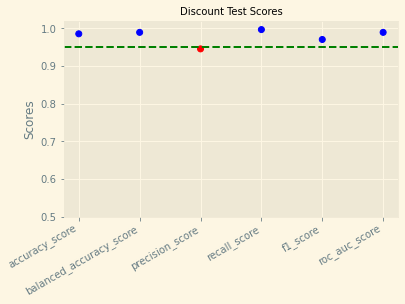

In [40]:
# Plot the data
x,y = df['metric'], df['score']
plt.scatter(x, y, c=['r' if k<.95 else 'b' for k in y ])
plt.axhline(y=0.95, color='g', linestyle='--')
plt.ylim(bottom=.5,top=1.02)

# Add labels
plt.ylabel("Scores")
# plt.suptitle("Bogo Test Scores", size=14)
plt.title("Discount Test Scores", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()
plt.show()